## Imports

In [5]:
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install pylatexenc==2.10
!pip install qiskit_ibm_runtime==0.34.0

In [6]:
import qiskit
import qiskit_aer
from qiskit.quantum_info import Statevector, Operator, state_fidelity, random_statevector
from qiskit.circuit.library import real_amplitudes, EfficientSU2, TwoLocal, PauliTwoDesign
from qiskit import transpile
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from math import ceil
import numpy as np
import time
import math
from scipy.optimize import minimize
from scipy.stats import unitary_group, ortho_group
print(f"Qiskit version: {qiskit.__version__}")
print(f"Qiskit-Aer version: {qiskit_aer.__version__}")

Qiskit version: 2.0.0
Qiskit-Aer version: 0.17.0


# Trials

To re-summarize the VQLS algorithm, we rely on a variational quantum algorithm to solve Ax=b by having x modeled as a parameterized ansatz and evaluted Ax by applying some unitary operator A on x(theta). As in a VQE, we rely on a classical optimizer (in this case COBYLA) to minimize a cost function and tune the parameters of x(theta) accordingly. For the algorithm, we define the cost as 1-fidelity, where fidelity measures how close the quantum states Ax(theta) and b are.

In the previous notebook, we examined how the cost function, and thus fidelity behaves for various ansatz (EfficientSU2, TwoLocal, PauliTwoDesign, and RealAmplitudes) for some random yet specific variables A and b. We also demonstrated effects of other factors like the depth of the circuit (number of qubits/number of reps for the ansatz) and more general linear systems than conventionally modeled by quantum systems could be addressed with the VQLS algorithm.

In this notebook, we now seek to only look at the final outputs and associated factors of running the VQLS algorithm on different ansatze, which will be done by running the minimize (of the cost function) 100 times for each ansatze, using a different random A operator and b output for each trial. We will consider: the final fidelity, the number of iterations taken to converge (or if it reaches a max of 1000), and the time taken to converge. We will also consider and test out a noisy model with the Aer simulator.

Many of the graphs, especially for the fidelity vs iterations, are repeated, with different magnifications to better see the points

I would not recommend you run this code on your own, by the way, since it generally takes over half an hour per 100 runs.

## Function Defs

### Cost Function

The cost functions are largely the same, though we don't care about the cost list as the minimize happens, just the final outcome.

In [ ]:
def cost_function(params, ansatz, b_state, A):
    bound_ansatz = ansatz.assign_parameters(params) #bounds the specified parameters to the ansatz
    op = Operator(A)

    bound_ansatz.unitary(op, [0,1]) #apply the unitary, making the circuit represent Ax(theta)
    bound_ansatz.save_statevector() #Saves Ax(theta) statevector

    backend = Aer.get_backend('aer_simulator')
    transpiled_ansatz = transpile(bound_ansatz, backend)
    result = backend.run(transpiled_ansatz, shots=100).result()
    ansatz_state = result.get_statevector(transpiled_ansatz, decimals=10) #gets the statevector of Ax(theta) with aer simulator

    cost = 1 - state_fidelity(ansatz_state, b_state)
    return cost

We define a new cost function specifically for doing a noisy simulation with the Aer Simulator, for convenience.

In [9]:
# We define a consistent noise model accross all trials for the following 1 and 2 qubit gates
noise_model = NoiseModel()
dep_error_1q = depolarizing_error(0.01, 1)
dep_error_2q = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(dep_error_1q, ['rx', 'ry', 'rz'])
noise_model.add_all_qubit_quantum_error(dep_error_2q, ['cx'])

def noisy_cost_function(params, ansatz, b_state, A):
    bound_ansatz = ansatz.assign_parameters(params)
    op = Operator(A)
    bound_ansatz.unitary(op, [0,1])
    bound_ansatz.save_statevector() #Saves Ax(theta) statevector

    backend = AerSimulator(noise_model=noise_model)
    transpiled_ansatz = transpile(bound_ansatz, backend)
    result = backend.run(transpiled_ansatz, shots=100).result()
    ansatz_state = result.get_statevector(transpiled_ansatz, decimals=10) #gets the statevector of Ax(theta) with aer simulator

    cost = 1 - state_fidelity(ansatz_state, b_state)
    return cost

### Function for minimization

For the cost function, we iterate 100 times, using a new A operator and b result each time. The # of iterations, time taken, and fidelity and stored in the dictionary that is returned

In [ ]:
def minimize_cost_function(ansatz, func):
    return_dict = {}

    for i in range(0, 100):
        rv = unitary_group.rvs(dim=4)
        vec = random_statevector(4) #arbitary statevector of x, to ensure system is solvable later
        vector = vec.data
        b = np.matmul(rv, vector) #find a b vector that can actually be reached by Ax(theta), so the system is solvable
        b_state = Statevector(b) #statevector of the array for b

        start_time = time.perf_counter() #tracks time
        result = minimize(func, x0=[float(random.randint(0,3000))/1000 for i in range(0, ansatz.num_parameters)], args=(ansatz, b_state, rv),method = 'COBYLA', options={'maxiter': 1000})
        end_time = time.perf_counter()
        #maxiter set to 1000, shouldn't need more than that to converge

        #dictionary storing the number of iterations (result['nfev']), time taken, and fidelity (result['fun'] is the cost function)
        #the key stores which # trial it was, so all are accounted for
        return_dict[i] = (result['nfev'], end_time - start_time, 1 - result['fun'])
    return return_dict

### Graph functions

Functions to graph, miny and maxy and the min and max y values to be shown on the graph, to help with viewability.

In [ ]:
def fidelity_against_iterations(dict, miny):
    iterations = [value[0] for value in dict.values()] #iterations are stored in value[0]
    fidelities = [value[2] for value in dict.values()] #fidelities are stored in value[2]
    plt.scatter(iterations, fidelities, color='blue', label='Data points')

    # Add labels and title
    plt.xlabel('Number of iterations')
    plt.ylabel('Fidelity')
    plt.title('Fidelity vs. Number of iterations')

    #no scientific notation
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
    plt.gca().yaxis.get_major_formatter().set_scientific(False)
    
    plt.ylim(miny,1)

    # Show plot
    plt.grid(True)
    plt.show()

Due to the direct correlation between the time and number of iterations taken, this graph also includes a line of best fit.

In [24]:
def times_against_iterations(dict, maxy):
    iterations = np.array([value[0] for value in dict.values()]) #iterations are stored in value[0]
    times = np.array([value[1] for value in dict.values()]) #times are stored in value[1]
    plt.scatter(iterations, times, color='blue', label='Data points')

    #getting the line of best fit
    coefficients = np.polyfit(iterations, times, 1)
    slope, intercept = coefficients
    line = slope * iterations + intercept
    plt.plot(iterations, line, color='red', label=f'Best fit: y={slope:.2f}x+{intercept:.2f}')

    # Add labels and title
    plt.xlabel('Number of iterations')
    plt.ylabel('Time (seconds)')
    plt.title('Time taken vs. Number of iterations')

    #no scientific notation
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
    plt.gca().yaxis.get_major_formatter().set_scientific(False)
    plt.ylim(0, maxy)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return "y="+str(slope) +"x+"+str(intercept)

## EfficientSU2 Ansatz

In [100]:
ansatz = EfficientSU2(2, reps=2, entanglement='linear')

Number of parameters: 12


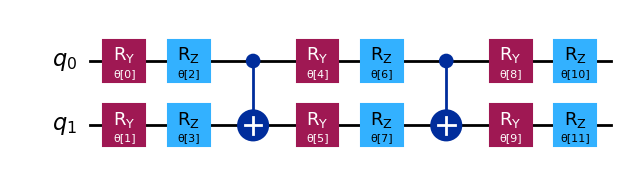

In [101]:
print("Number of parameters:", ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [ ]:
dict_ESU2 = minimize_cost_function(ansatz, cost_function)

In [230]:
print(dict_ESU2)

{0: (188, 25.204727399977855, 0.9999999956844856), 1: (210, 28.143789599998854, 0.9999999960318224), 2: (394, 53.16622010001447, 0.999999991052458), 3: (448, 63.625585500034504, 0.9999999661988052), 4: (309, 42.56259650003631, 0.999999985069335), 5: (215, 27.498922800004948, 0.9999999943277433), 6: (192, 24.580906499992125, 0.9999999921882856), 7: (224, 31.116094500001054, 0.9999999987443937), 8: (179, 23.997083099966403, 0.9999999983788248), 9: (223, 32.182235300017055, 0.9999999981709402), 10: (193, 24.434844099974725, 0.9999999976413356), 11: (187, 25.01687580003636, 0.9999999949866103), 12: (186, 23.04329120001057, 0.9999999967081912), 13: (215, 26.167138000018895, 0.9999999975210241), 14: (250, 30.359993099991698, 0.9999999913367199), 15: (224, 27.886860600032378, 0.9999999967828985), 16: (213, 26.13483349996386, 0.9999999982026482), 17: (209, 25.660527299973182, 0.9999999991642274), 18: (231, 29.68476680002641, 0.9999999950615277), 19: (196, 23.99641550000524, 0.9999999915504811)

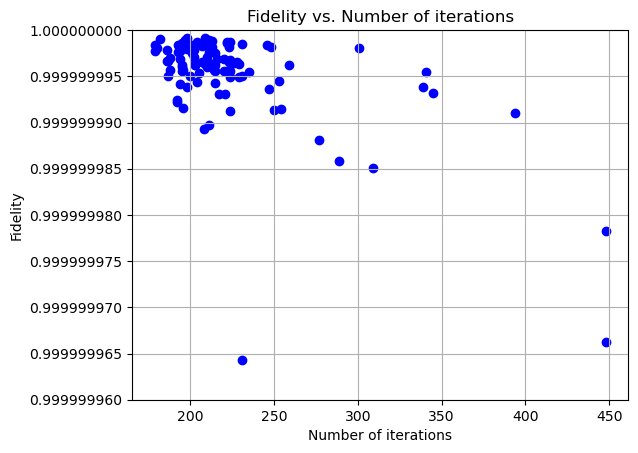

In [23]:
fidelity_against_iterations(dict_ESU2, 0.99999996)

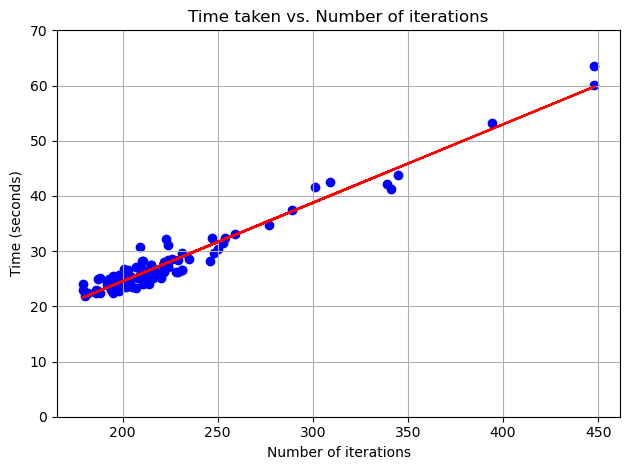

y=0.14213038307672018x+-3.88024665420021


In [27]:
esu2_line = times_against_iterations(dict_ESU2, 70)
print(esu2_line)

### Noisy Simulations

In [ ]:
dict_ESU2_noisy = minimize_cost_function(ansatz, noisy_cost_function)
print(dict_ESU2_noisy)

{0: (288, 26.203902400040533, 0.5333264452266568), 1: (276, 25.144511899969075, 0.03593343033077545), 2: (289, 27.87676489999285, 0.9999999531453746), 3: (293, 30.506638500024565, 0.9999999991095332), 4: (208, 19.30355320003582, 0.1170060452566194), 5: (95, 8.718807100027334, 0.014456264246980655), 6: (266, 24.916276400035713, 0.9999891046355134), 7: (366, 33.59230090002529, 0.9994356012386633), 8: (108, 9.775550499965902, 0.03614768000822921), 9: (168, 15.232234199997038, 0.9720817213530323), 10: (233, 21.806058100017253, 0.9999999952701915), 11: (375, 35.161898599995766, 0.9674736223174103), 12: (279, 25.458207399991807, 0.9999932475778412), 13: (112, 10.593137499992736, 0.015110083809528607), 14: (278, 27.72821579995798, 0.9999984411095626), 15: (322, 32.19186510000145, 0.4329497638561699), 16: (102, 10.876865099999122, 0.00029398077633580044), 17: (277, 27.854329800000414, 0.9999858618271639), 18: (229, 22.99086169997463, 0.9999999712309471), 19: (251, 25.339823700021952, 0.9999999

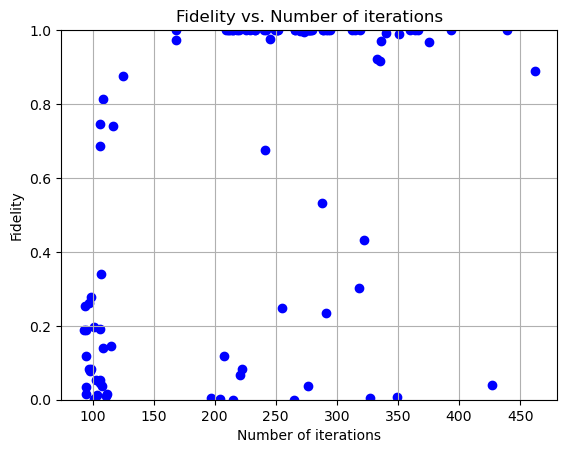

In [29]:
fidelity_against_iterations(dict_ESU2_noisy, 0)

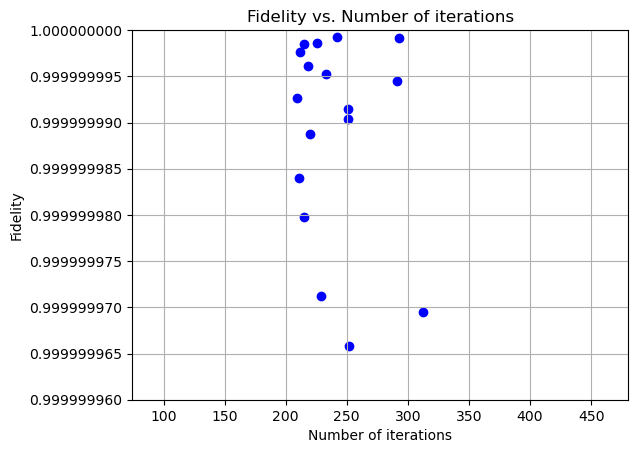

In [237]:
fidelity_against_iterations(dict_ESU2_noisy, 0.99999996)

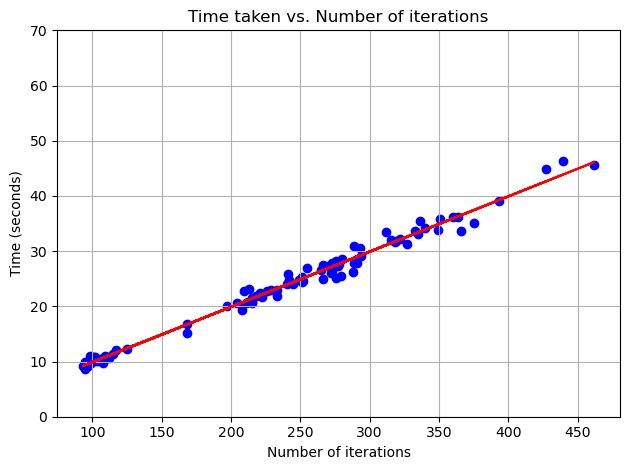

y=0.10015094042521996x+-0.1361521790104234


In [30]:
esu2_line_noisy = times_against_iterations(dict_ESU2_noisy, 70)
print(esu2_line_noisy)

## PauliTwoDesign, 2 Reps

In [102]:
ansatz = PauliTwoDesign(num_qubits=2, reps=2)

Number of parameters: 6


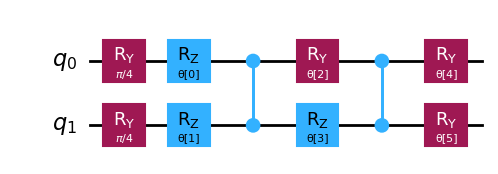

In [103]:
print("Number of parameters:", ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [ ]:
dict_PT2 = minimize_cost_function(ansatz, cost_function)
print(dict_PT2)

{0: (140, 18.343311900040135, 0.8780747729205093), 1: (565, 78.7522486000089, 0.9653400974878112), 2: (191, 26.77868629997829, 0.9443255842104693), 3: (350, 44.204982800001744, 0.9384278301155768), 4: (122, 14.78425889997743, 0.997056317773513), 5: (361, 45.12455160001991, 0.973445017786106), 6: (127, 15.488481900014449, 0.8948338450778773), 7: (158, 19.556776700017508, 0.995914876497944), 8: (113, 14.730281899974216, 0.924344228355633), 9: (162, 20.597077899961732, 0.9964053915388174), 10: (849, 103.48333120002644, 0.9441566523486713), 11: (118, 14.11778150004102, 0.9934077403004478), 12: (292, 35.44853990001138, 0.9050362625949191), 13: (149, 19.84164050000254, 0.9944077179679897), 14: (126, 16.59212899999693, 0.9111664445364348), 15: (126, 17.05960039998172, 0.9650683413397604), 16: (121, 16.41390710003907, 0.969395777701242), 17: (142, 17.30099830002291, 0.9111165083497159), 18: (187, 21.947150900028646, 0.957030960405485), 19: (126, 14.676756200031377, 0.981554313868159), 20: (170

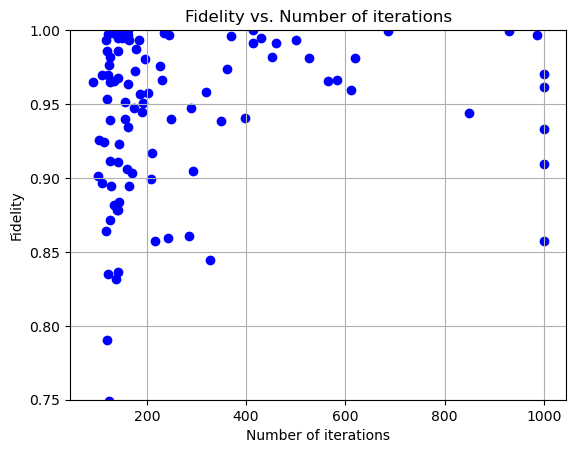

In [32]:
fidelity_against_iterations(dict_PT2, 0.75)

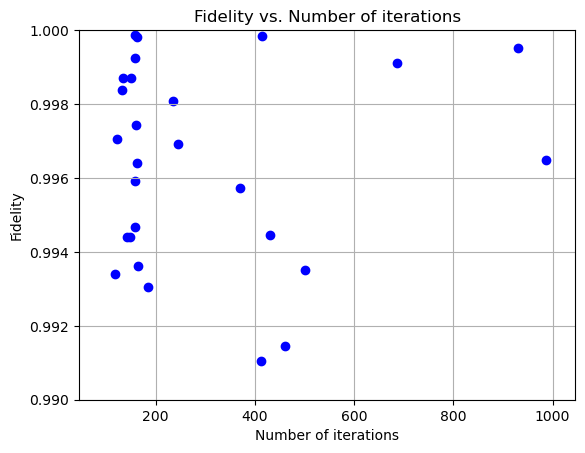

In [241]:
fidelity_against_iterations(dict_PT2, 0.99)

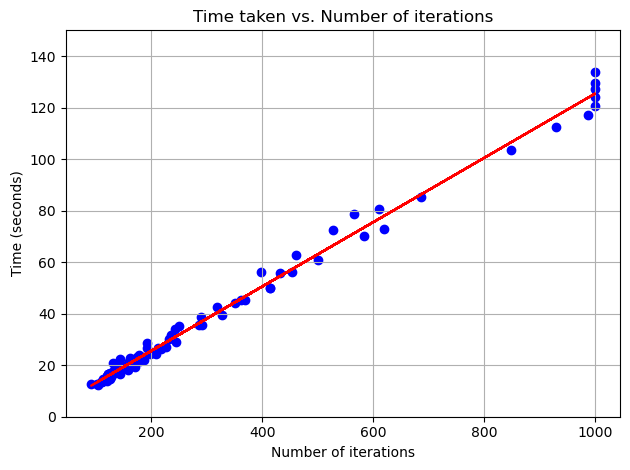

y=0.12467072931863818x+0.7066362493830611


In [33]:
pt2_line = times_against_iterations(dict_PT2, 150)
print(pt2_line)

### Noisy Simulations

In [ ]:
dict_PT2_noisy = minimize_cost_function(ansatz, noisy_cost_function)
print(dict_PT2_noisy)

{0: (140, 15.739328800002113, 0.9658076016870017), 1: (157, 21.402644800022244, 0.6688778310645791), 2: (55, 6.182125199993607, 0.05917095311156095), 3: (55, 6.541746799950488, 0.24565478978586386), 4: (159, 18.093117799959145, 0.5092101891380654), 5: (62, 6.991324800008442, 0.0776809115308369), 6: (171, 18.707449699984863, 0.30256425007502286), 7: (59, 7.028442999988329, 0.4290829593906287), 8: (180, 19.17531510000117, 0.9452803778993398), 9: (162, 17.540441899967846, 0.9530198461643209), 10: (54, 5.874237700016238, 0.15180227826929527), 11: (208, 22.427850000036415, 0.012793780218408046), 12: (56, 5.57208279997576, 0.10131955448096464), 13: (60, 6.422599699988496, 0.48773028347571257), 14: (65, 6.584689699986484, 0.14544358328259233), 15: (135, 13.886594899988268, 0.9998916303914213), 16: (57, 5.839868600014597, 0.4916875200005323), 17: (53, 5.516620500013232, 0.2826305572249843), 18: (183, 18.8912241999642, 0.9492862705357031), 19: (385, 38.79287940001814, 0.8797199523644018), 20: (

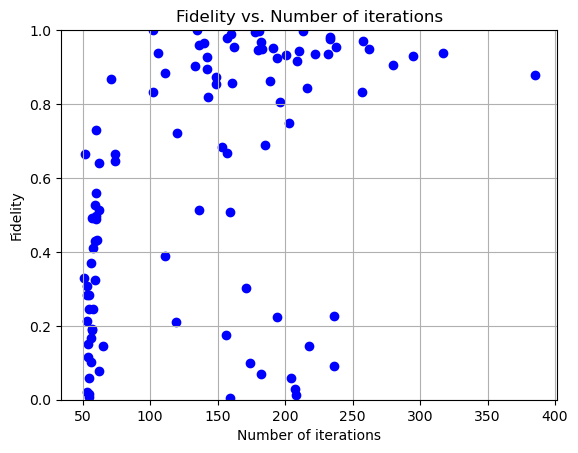

In [244]:
fidelity_against_iterations(dict_PT2_noisy, 0)

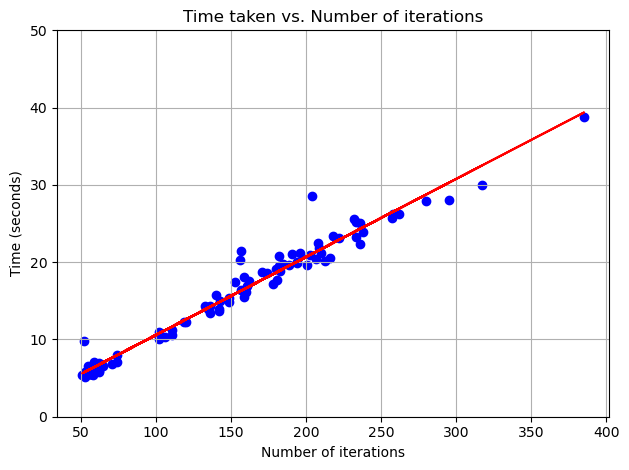

y=0.10106737985581458x+0.45490253906590256


In [35]:
pt2_line_noisy = times_against_iterations(dict_PT2_noisy, 50)
print(pt2_line_noisy)

## PauliTwoDesign, 5 Reps

In [144]:
ansatz = PauliTwoDesign(num_qubits=2, reps=5)

Number of parameters: 12


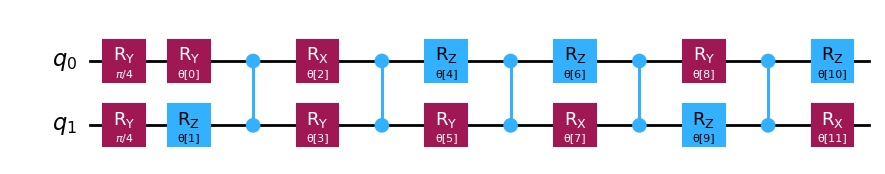

In [145]:
print("Number of parameters:", ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [ ]:
dict_PT5 = minimize_cost_function(ansatz)
print(dict_PT5)

{0: (214, 28.103638500033412, 0.9999999950042224), 1: (216, 28.985306000045966, 0.999999996255112), 2: (424, 57.82291190000251, 0.9999999926815157), 3: (226, 30.05150370002957, 0.999999991848169), 4: (215, 29.086245999962557, 0.9999999987031116), 5: (205, 30.32255179999629, 0.9999999961985968), 6: (202, 28.035666199983098, 0.9999999988402848), 7: (220, 29.00601519999327, 0.9999999981853327), 8: (293, 36.60594779998064, 0.9999999898663183), 9: (201, 29.26595020003151, 0.9999999972727318), 10: (204, 30.065420600003563, 0.9999999907603458), 11: (185, 25.395367000019178, 0.9999999960283046), 12: (188, 24.418904800026212, 0.9999999955840793), 13: (198, 26.568067400017753, 0.9999999976685439), 14: (198, 25.846266000007745, 0.9999999962938659), 15: (223, 29.748198300017975, 0.9999999939920796), 16: (244, 32.49463760002982, 0.9999999919790394), 17: (372, 49.630979600013234, 0.9999999846534507), 18: (244, 34.11278990004212, 0.9999999993833526), 19: (246, 32.681556799972896, 0.9999999957682886),

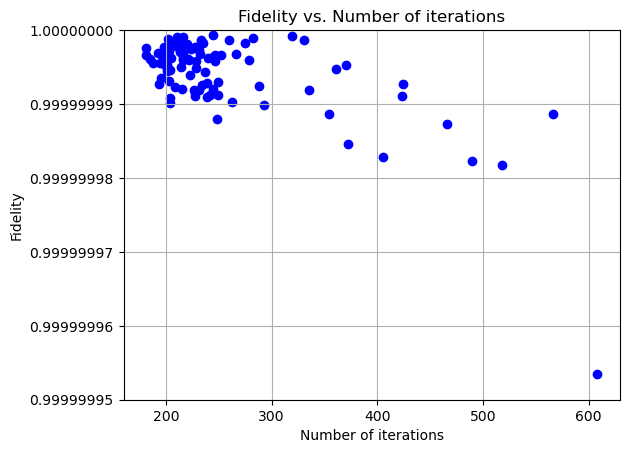

In [249]:
fidelity_against_iterations(dict_PT5, 0.99999995)

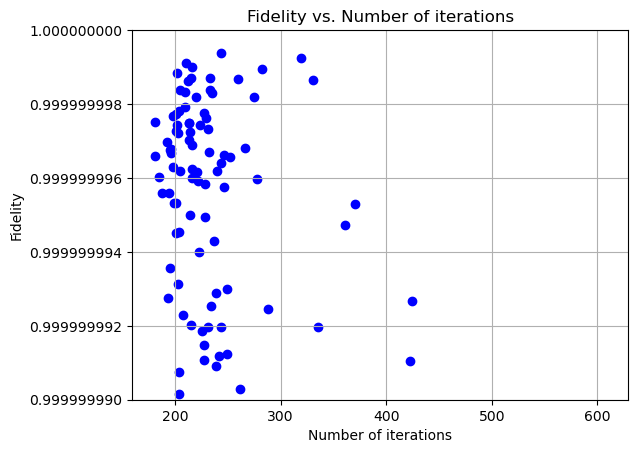

In [256]:
fidelity_against_iterations(dict_PT5, 0.99999999)

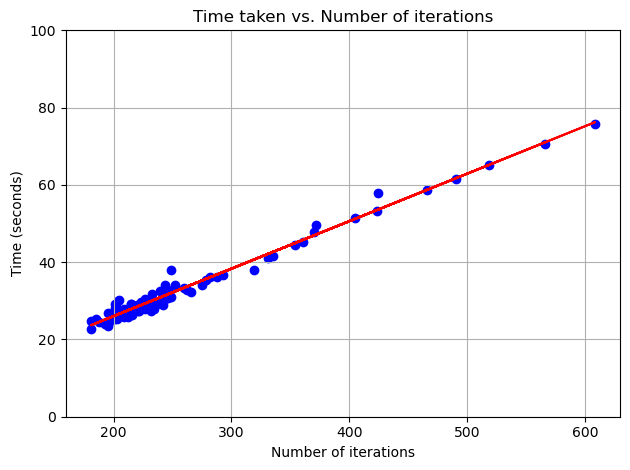

y=0.12299539871207385x+1.4234755270246495


In [37]:
pt5_line = times_against_iterations(dict_PT5, 100)
print(pt5_line)

### Noisy Simulations

In [ ]:
dict_PT5_noisy = minimize_cost_function(ansatz, noisy_cost_function)
print(dict_PT5_noisy)

{0: (276, 28.18931360001443, 0.9606420099275897), 1: (232, 23.437339500000235, 0.9999999982141774), 2: (99, 9.99185240000952, 0.4729127195035695), 3: (350, 35.335422199976165, 0.9773012820911612), 4: (345, 34.54751880001277, 0.9995295607111395), 5: (211, 21.49134840001352, 0.9999999980369119), 6: (248, 25.074733200017363, 1.834308649417693e-08), 7: (202, 20.308384000032675, 0.9999999975058793), 8: (119, 11.884269599977415, 0.8760329609140493), 9: (232, 23.286490999977104, 0.9999999846329252), 10: (97, 9.951310199976433, 0.011064485570171922), 11: (352, 35.403111800027546, 0.9971790382341814), 12: (234, 23.57739400002174, 0.09061852272917614), 13: (333, 33.73891130002448, 0.9998755554482565), 14: (363, 36.41286449995823, 0.5698673482671659), 15: (103, 10.452127099968493, 0.0538415559592853), 16: (370, 37.245064300019294, 0.9857170895296876), 17: (250, 24.947012200020254, 0.999991844185905), 18: (109, 10.870362300018314, 0.2246843070963629), 19: (133, 13.25023509998573, 0.812935226010756

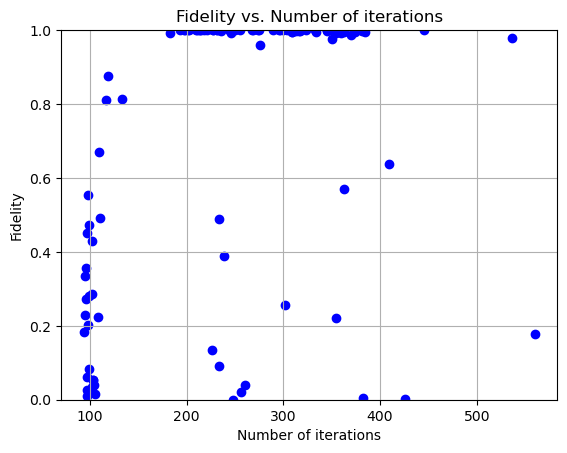

In [252]:
fidelity_against_iterations(dict_PT5_noisy, 0)

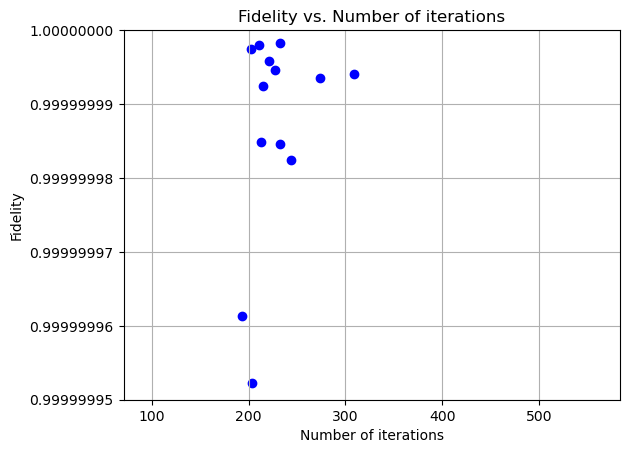

In [254]:
fidelity_against_iterations(dict_PT5_noisy, 0.99999995)

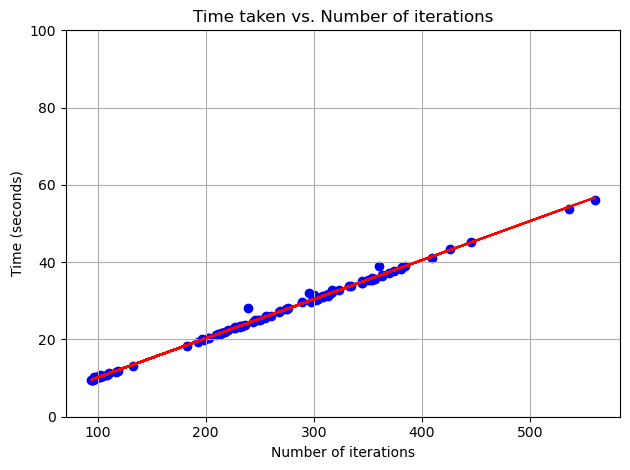

y=0.1012083966388482x+0.03637951332217426


In [40]:
pt5_line_noisy = times_against_iterations(dict_PT5_noisy, 100)
print(pt5_line_noisy)

## TwoLocal

In [ ]:
ansatz = TwoLocal(num_qubits=2, rotation_blocks=['rx', 'rz'], entanglement_blocks='cx', entanglement='linear', reps=2)

Number of parameters: 12


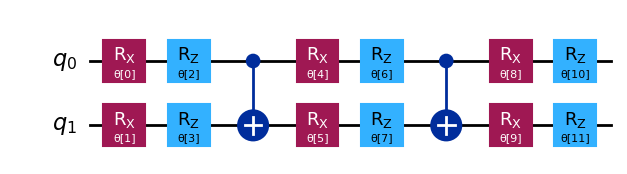

In [118]:
print("Number of parameters:", ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [ ]:
dict_twolocal = minimize_cost_function(ansatz, cost_function)
print(dict_twolocal)

{0: (336, 45.001344999996945, 0.999999995630779), 1: (230, 29.590818199969362, 0.9999999921217368), 2: (223, 29.115752500016242, 0.9999999975647498), 3: (203, 25.309732099995017, 0.999999998249925), 4: (248, 30.784199299989268, 0.9999999930446426), 5: (208, 25.93186849995982, 0.999999995694058), 6: (201, 24.76302030001534, 0.9999999952178822), 7: (253, 31.279112600022927, 0.9999999934233434), 8: (220, 27.28914499998791, 0.9999999983954424), 9: (204, 25.37273629999254, 0.999999992434184), 10: (205, 25.80897479999112, 0.9999999974308555), 11: (284, 40.535355900006834, 0.9999999964277688), 12: (193, 26.42420279997168, 0.999999995044254), 13: (203, 27.58452779997606, 0.9999999974098026), 14: (200, 26.051672800036613, 0.9999999975815881), 15: (214, 28.85267799999565, 0.9999999997228823), 16: (242, 31.874764700012747, 0.9999999933901711), 17: (219, 29.901803499960806, 0.9999999956538603), 18: (222, 28.82272609998472, 0.9999999972129565), 19: (451, 56.94472420000238, 0.9999999855850268), 20: 

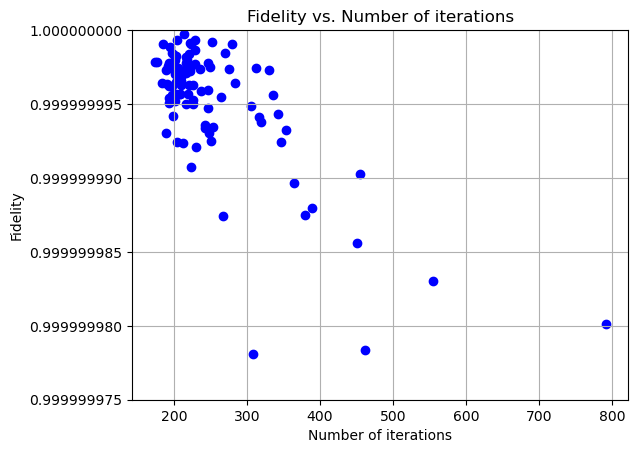

In [260]:
fidelity_against_iterations(dict_twolocal, 0.999999975)

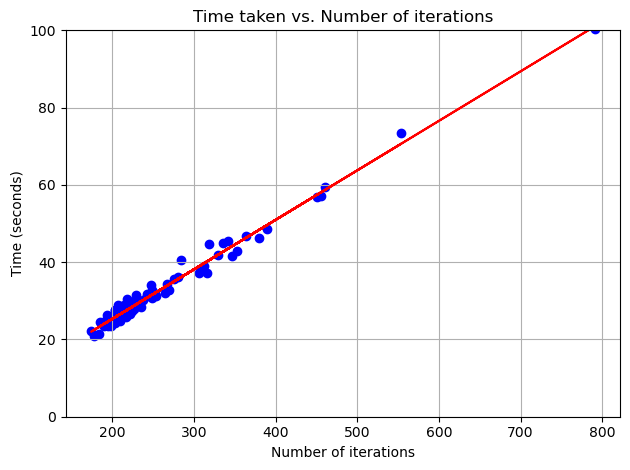

y=0.1281004688380314x+-0.29399645995791845


In [42]:
tl_line = times_against_iterations(dict_twolocal, 100)
print(tl_line)

### Noisy Simulations

In [ ]:
dict_twolocal_noisy = minimize_cost_function(ansatz, noisy_cost_function)
print(dict_twolocal_noisy)

{0: (96, 8.627407699998002, 0.3381009299539708), 1: (360, 33.80719620001037, 1.0064770734619088e-06), 2: (109, 10.45568660000572, 0.11308377673332959), 3: (259, 24.544859399960842, 0.9124976588371658), 4: (379, 36.40532230003737, 0.16202948377619097), 5: (388, 36.784045699983835, 0.25119625119751365), 6: (389, 38.29032760002883, 0.9904195137728298), 7: (216, 20.486637599999085, 0.08243367132432089), 8: (92, 8.777267900004517, 0.10909360263008527), 9: (106, 10.125316200021189, 0.16181508776753772), 10: (222, 21.636375799949747, 0.9999999852173549), 11: (321, 30.513193399994634, 0.9967424394732802), 12: (99, 9.565002700022887, 0.09963275436549335), 13: (247, 24.171151000016835, 0.9999999886090627), 14: (204, 20.82272749999538, 0.999999660542284), 15: (103, 11.07329040003242, 0.08528464797974766), 16: (369, 38.46961159998318, 0.01498897949024014), 17: (308, 33.14698879997013, 0.9976862557629752), 18: (296, 30.767602600040846, 0.004825997803515114), 19: (304, 32.73618520004675, 0.205240167

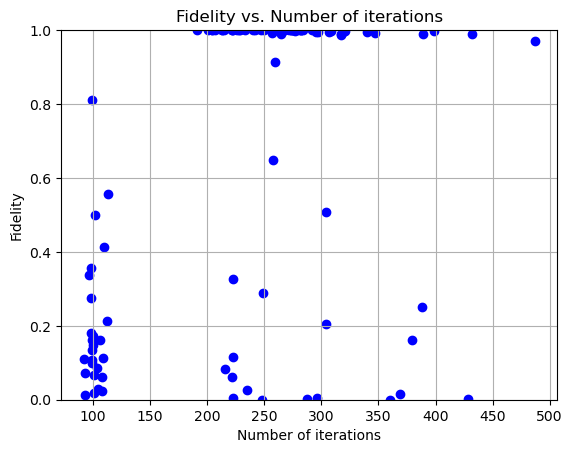

In [262]:
fidelity_against_iterations(dict_twolocal_noisy, 0)

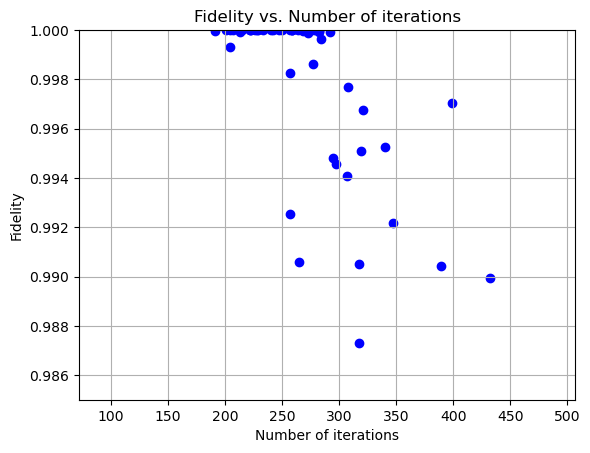

In [264]:
fidelity_against_iterations(dict_twolocal_noisy, 0.985)

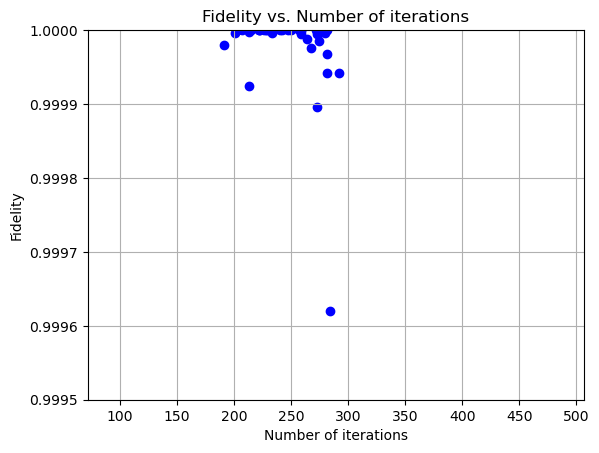

In [268]:
fidelity_against_iterations(dict_twolocal_noisy, 0.9995)

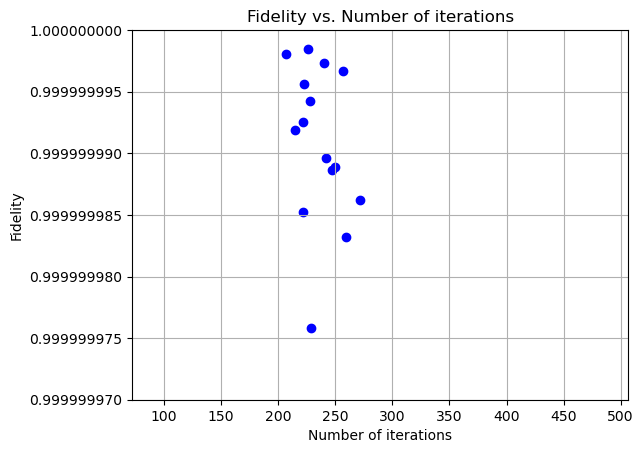

In [269]:
fidelity_against_iterations(dict_twolocal_noisy, 0.99999997)

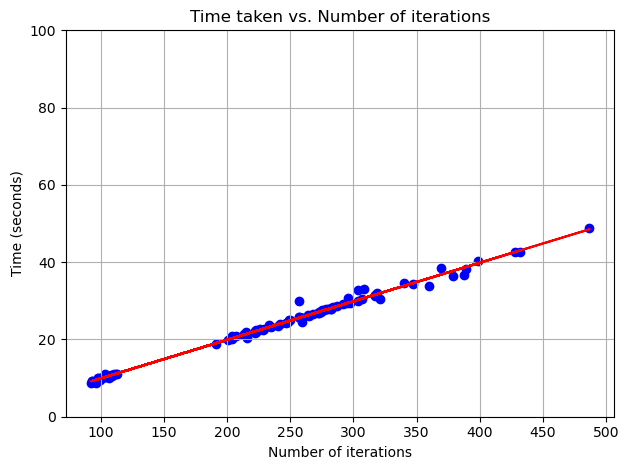

y=0.09966628052201422x+-0.025255393925567658


In [44]:
tl_line_noisy = times_against_iterations(dict_twolocal_noisy, 100)
print(tl_line_noisy)

## RealAmplitudes

In [361]:
ansatz = real_amplitudes(2, reps=2, entanglement='linear')

Number of parameters: 6


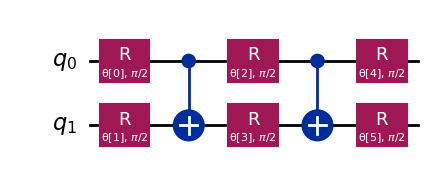

In [362]:
print("Number of parameters:", ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [363]:
def normalize(vec):
    norm = np.linalg.norm(vec)
    if norm == 0:
        return vec
    return vec / norm

We quickly define a minimize cost function function for RealAmplitudes, only taking in matrices and vectors with real coefficients.

In [ ]:
def minimize_cost_function_real(ansatz, func):
    return_dict = {}

    for i in range(0, 100):
        rv = ortho_group.rvs(dim=4) #rv is an orthogonal matrix, all real coefficients
        vect = [random.uniform(-10, 10) for i in range(0, 4)]
        normvect = normalize(vect) #normalized solution vector, x, all real
        b_real = np.matmul(rv, normvect) #find a b vector that can actually be reached by Ax(theta), so the system is solvable
        b_real_state = Statevector(b_real)

        start_time = time.perf_counter() #to collect time taken for a trial
        result = minimize(func, x0=[float(random.randint(0,3000))/1000 for i in range(0, ansatz.num_parameters)], args=(ansatz, b_real_state, rv),method = 'COBYLA', options={'maxiter': 1000})
        end_time = time.perf_counter()
        #maxiter set to 1000, shouldn't need more than that to converge

        #dictionary storing the number of iterations, time taken, and fidelity
        return_dict[i] = (result['nfev'], end_time - start_time, 1 - result['fun'])
    return return_dict

In [371]:
dict_realamplitudes = minimize_cost_function_real(ansatz, cost_function)
print(dict_realamplitudes)

{0: (82, 9.89419350004755, 0.999999997747079), 1: (112, 13.764482800033875, 0.9999999949112068), 2: (93, 11.265020299935713, 0.9999999863867588), 3: (91, 18.787576099974103, 0.999999992735054), 4: (95, 36.342894900008105, 0.9999999982762786), 5: (93, 30.506735900067724, 0.9999999973038596), 6: (94, 31.618934100028127, 0.9999999981262317), 7: (97, 31.208399800001644, 0.9999999979524927), 8: (90, 27.900458900025114, 0.999999995005715), 9: (90, 29.68985170009546, 0.9999999947132756), 10: (94, 28.790769800078124, 0.9999999980260332), 11: (91, 27.24178809998557, 0.9999999959356165), 12: (93, 31.112427299958654, 0.9999999979664911), 13: (74, 24.026129100006074, 0.9999999936037682), 14: (84, 29.9180059999926, 0.9999999985854331), 15: (89, 29.142673199996352, 0.9999999936427411), 16: (90, 29.724617200088687, 0.9999999995707325), 17: (96, 30.776356999995187, 0.9999999921061453), 18: (93, 30.03925839997828, 0.9999999945211706), 19: (104, 34.56902709999122, 0.9999999971349147), 20: (96, 30.108907

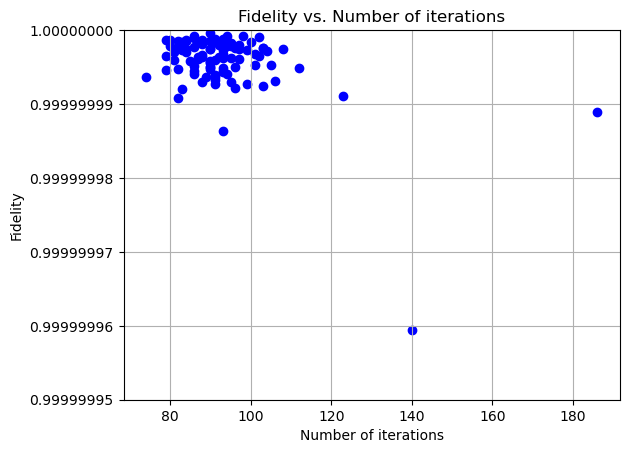

In [382]:
fidelity_against_iterations(dict_realamplitudes, 0.99999995)

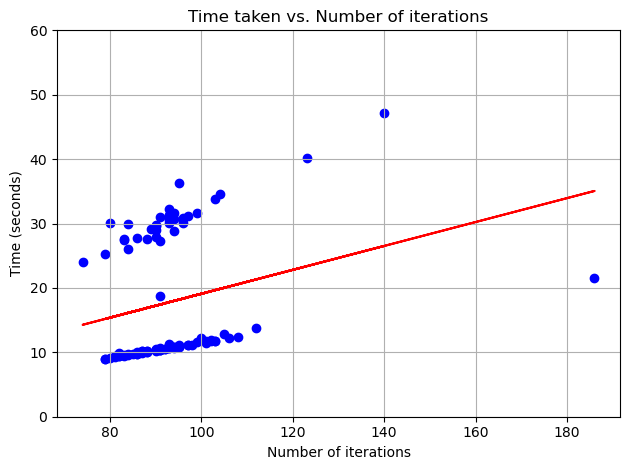

y=0.18555963295376626x+0.5416114722704151


In [46]:
ra_line = times_against_iterations(dict_realamplitudes, 60)
print(ra_line)

### Noisy Simulations

In [372]:
dict_realamplitudes_noisy = minimize_cost_function_real(ansatz, noisy_cost_function)
print(dict_realamplitudes_noisy)

{0: (116, 9.499959300039336, 0.15507854328537873), 1: (96, 8.241067800088786, 0.9999999952040366), 2: (105, 9.037709499942139, 0.9999996943860701), 3: (90, 7.939131700084545, 3.5720404412131757e-10), 4: (116, 10.01577149995137, 0.9998811042263143), 5: (106, 9.174488499993458, 0.02175547746905515), 6: (92, 7.846201099921018, 0.9999999960412249), 7: (74, 6.477861299994402, 0.9901406047067786), 8: (90, 7.760751800029539, 0.9999999978863503), 9: (54, 4.669963099993765, 0.1384423434153229), 10: (87, 7.505041999975219, 0.9999999986733401), 11: (98, 8.840920499991626, 0.9999999963013511), 12: (101, 8.789518799982034, 0.999999997592391), 13: (88, 7.6951306000119075, 0.9999999950455902), 14: (105, 9.193206500029191, 0.3001309572191244), 15: (83, 7.343443299992941, 0.9999999972268632), 16: (98, 8.778583999956027, 0.9999999925202374), 17: (105, 9.293726500007324, 0.9999999986146444), 18: (162, 14.796551199979149, 0.3176547286678978), 19: (82, 7.26798050000798, 0.9999999980652212), 20: (84, 7.4715

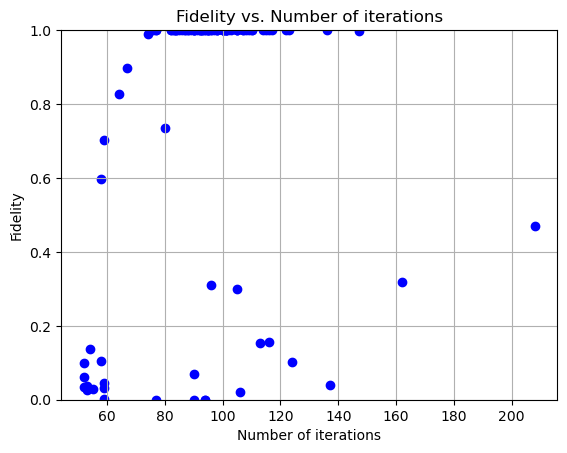

In [387]:
fidelity_against_iterations(dict_realamplitudes_noisy, 0)

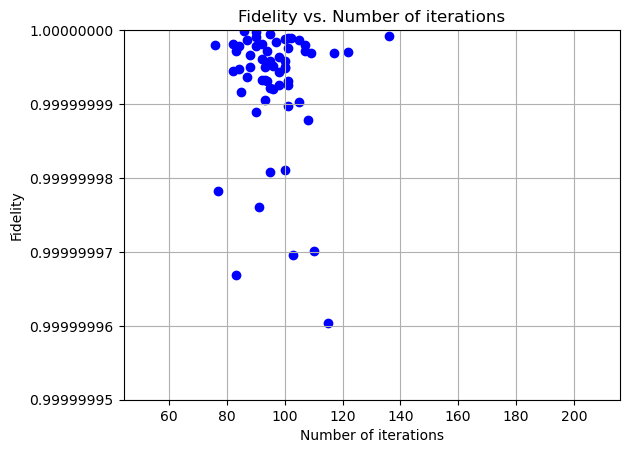

In [389]:
fidelity_against_iterations(dict_realamplitudes_noisy, 0.99999995)

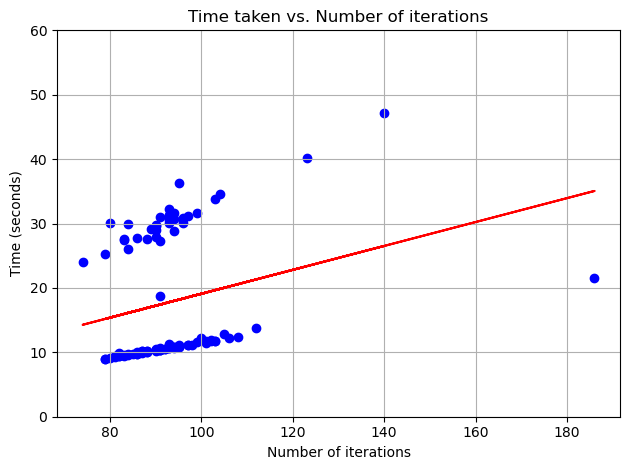

y=0.18555963295376626x+0.5416114722704151


In [48]:
ra_line_noisy = times_against_iterations(dict_realamplitudes, 60)
print(ra_line_noisy)